# 🛡️📧 Phishing Email Detection Project 

## What’s This Project About?

This project focuses on **detecting phishing emails** — those tricky emails that try to fool people into giving away passwords, credit card info, or clicking harmful links. Phishing is a big cybersecurity threat that can cause identity theft, money loss, and damage to companies’ reputations.

## 📚 About the Dataset 

The dataset used here is the **CEAS 2008 Email Dataset (CEAS_08)**, a well-known collection of emails for phishing research. It contains thousands of emails, both **phishing** and **legitimate** (safe), labeled for training machine learning models.  

Each email in the dataset includes:  
- The raw email text (including headers and body)  
- Labels marking whether the email is phishing or not  
- Extracted metadata like sender email address, URLs found in the email, and domains of those URLs

You can learn more about this dataset here: [CEAS 2008 Dataset Details](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset)  

This dataset provides a rich variety of examples to help models learn what makes phishing emails different from real ones.

## 🎯 The Goal 

The main aim is to create a **machine learning model** that can automatically detect phishing emails by analyzing their content and metadata. This means:  
- Helping users and companies block phishing before harm is done  
- Protecting personal and financial information  
- Saving time by automating email security  
- Enhancing existing email filtering and cybersecurity systems

## 💼 Why This Matters for Business 

- **Prevents phishing attacks** before they reach employees or customers  
- **Reduces financial loss and fraud risk** by catching scams early  
- **Increases trust and safety** in company communications  
- **Saves time and costs** by automating email threat detection  
- **Can be integrated** with email gateways, security platforms, or customer support tools to boost protection

## 🚀 Summary 

This project uses a popular phishing email dataset and combines smart text processing, feature engineering, and machine learning to build a reliable phishing detector. By understanding the words, links, and senders behind phishing emails, it helps protect people and businesses from online scams — making the internet a safer place, one email at a time! 🔒📬

# 📁 1. Imports

In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from urllib.parse import urlparse

import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)

from wordcloud import WordCloud

%matplotlib inline

[nltk_data] Downloading package wordnet to C:\Users\Denis
[nltk_data]     Garibovic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('CEAS_08.csv')
df.head(3)

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1


# 🔎 2. Email Feature Engineering

The following code is a toolkit for cleaning up and analyzing emails — especially to check if they might be phishing or spam. 

Here's what each part does and why it's helpful:

### 🧼 `clean_text(text)`

**Goal:** Strip the email down to just the meaningful words.

- Gets rid of HTML code.
- Turns everything into lowercase (makes it easier to compare words).
- Removes links, numbers, and punctuation (unless told to keep some like `!` or `?`).
- Cleans up extra spaces.

### 🪄 `preprocess_text(text)`

**Goal:** Break the text into words and optionally simplify them.

- Splits the sentence into individual words.
- Can remove boring/common words (stopwords). These are super common words like "the", "and", "it" that usually don’t add useful meaning. They're removed to focus on important stuff.
- Can reduce words to their base form (Lemmatizer). For example, "running", "ran", and "runs" all become "run".

### 🔗 `extract_urls(text)`

**Goal:** Pull out all website links from the email.

- Finds any URLs that start with "http" or "www".

### 🌍 `extract_domains(urls)`

**Goal:** Get the name of the website from each link.

- If a link is `http://paypal.badsite.com`, this pulls out `paypal.badsite.com`.

### 📬 `extract_sender_domain(sender)`

**Goal:** Get the domain (e.g., `paypal.com`) from the sender’s email address.

- Works even if the email looks fancy like `John <john@paypal.com>`.

### 🚨 `count_suspicious_words(text)`

**Goal:** Count how many red-flag words show up in the email.

- Words like "verify", "account", or "security" are counted. A higher count might mean the email is trying to trick someone.

### 💡 Why It Matters

This code helps clean up emails and pull out useful clues — like weird links, sketchy sender domains, and danger words. These clues can help a computer decide if an email is **legit** or **a scam**.

In [3]:
# Initialize global resources
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
SUSPICIOUS_WORDS = {'urgent', 'verify', 'account', 'password', 'click', 'login', 'bank', 'security'}

def clean_text(text, remove_urls=True, keep_punctuations=None):
    """
    Clean the input text:
    - Remove HTML tags
    - Lowercase text
    - Optionally remove URLs
    - Optionally keep certain punctuation (e.g., '!', '?') which may be phishing cues
    - Remove digits and extra whitespace
    """
    if not isinstance(text, str):
        return ''
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Lowercase
    text = text.lower()
    # Remove URLs if needed
    if remove_urls:
        text = re.sub(r'http[s]?://\S+|www\.\S+', ' ', text)
    
    # Optionally keep specific punctuation marks
    if keep_punctuations:
        pattern = f"[{re.escape(''.join(c for c in string.punctuation if c not in keep_punctuations))}]"
        text = re.sub(pattern, ' ', text)
    else:
        # Remove all punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r'\d+', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_text(text, remove_stopwords=True, do_lemmatize=False):
    """
    Tokenizes text, optionally removes stopwords, optionally lemmatizes.
    Returns cleaned text as a string.
    """
    if not isinstance(text, str):
        return ''
    
    tokens = text.split()
    
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]
    
    if do_lemmatize:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

def extract_urls(text):
    """
    Extract URLs from text.
    Returns a list of URLs.
    """
    if not isinstance(text, str):
        return []
    return re.findall(r'http[s]?://\S+|www\.\S+', text)

def extract_domains(urls):
    """
    Extract domain names from a list of URLs.
    Skips invalid or malformed URLs without crashing.
    """
    domains = []
    for url in urls:
        try:
            parsed = urlparse(url)
            domain = parsed.netloc.lower()
            if domain:
                domains.append(domain)
        except Exception:
            # Ignore invalid URLs
            continue
    return domains

def extract_sender_domain(sender):
    """
    Extracts domain from sender email address.
    Returns 'unknown' if missing or malformed.
    """
    if not isinstance(sender, str) or not sender.strip():
        return 'unknown'
    
    match = re.search(r'<([^<>]+)>', sender)
    email = match.group(1) if match else sender.strip()
    
    parts = email.split('@')
    if len(parts) == 2:
        return parts[1].lower()
    else:
        return 'unknown'

def count_suspicious_words(text):
    """
    Count number of suspicious phishing-related keywords in text.
    """
    if not isinstance(text, str):
        return 0
    tokens = text.split()
    return sum(token in SUSPICIOUS_WORDS for token in tokens)

# 🔨 3. Applying these functions to the Dataset

In [4]:
# Fill missing values safely
df['receiver'] = df['receiver'].fillna('unknown')
df['subject'] = df['subject'].fillna('(no subject)')
df['sender'] = df['sender'].fillna('unknown')
df['body'] = df['body'].fillna('')  # Also fill body missing values to avoid issues

# Combine subject + body into one text column
df['text'] = df['subject'] + ' ' + df['body']

# Clean the text: keep '!' and '?' since they can be phishing cues
df['clean_text'] = df['text'].apply(lambda x: clean_text(x, remove_urls=True, keep_punctuations={'!', '?'}))

# Remove stopwords and lemmatize (optional, you can toggle lemmatization)
df['clean_text'] = df['clean_text'].apply(lambda x: preprocess_text(x, remove_stopwords=True, do_lemmatize=True))

# Extract URLs separately for feature engineering
df['urls'] = df['text'].apply(extract_urls)
df['num_urls'] = df['urls'].apply(len)

# Extract domains from URLs for more granular features
df['url_domains'] = df['urls'].apply(extract_domains)

# Extract sender domain for categorical feature
df['sender_domain'] = df['sender'].apply(extract_sender_domain)

# Count suspicious words in the cleaned text as a feature
df['suspicious_word_count'] = df['clean_text'].apply(count_suspicious_words)

# Rearrange columns (added new features like url_domains, suspicious_word_count)
df = df[['sender', 'sender_domain', 'receiver', 'date', 'subject', 'body', 'num_urls', 'urls', 'url_domains', 'suspicious_word_count', 'text', 'clean_text', 'label']]

# Sample output
df.head(1)

,sender,sender_domain,receiver,date,subject,body,num_urls,urls,url_domains,suspicious_word_count,text,clean_text,label
0,Young Esposito <Young@iworld.de>,iworld.de,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,[http://whitedone.com/],[whitedone.com],0,"Never agree to be a loser Buck up, your troubl...",never agree loser buck trouble caused small di...,1


# 🤖 4. Building a Spam/Phishing Detection Model

This script teaches a computer how to detect phishing or spam emails using both the email's words and some simple numeric clues. Here's what each part does, step by step:

### 1️⃣ Turn Emails Into Numbers with TF-IDF

- TF-IDF turns words into numbers based on how important they are. It gives more weight to rare and meaningful words.
- It also looks at word pairs (like "click here") which are common in phishing.
- Words used too often or too rarely are ignored.

### 2️⃣ Add Extra Clues

- Adds more helpful features:
  - How many URLs are in the email.
  - How many suspicious words (like "urgent", "password", etc.) appear.
- These are common signs of phishing and help the model.

### 3️⃣ Combine Everything Into One Big Matrix

- Joins the TF-IDF text features and the extra numeric features into one large matrix.
- Now each email is represented by a long list of numbers.

### 4️⃣ Define the Target Labels

- This is the answer column: whether each email is phishing (`1`) or not (`0`).
- The model will try to learn to predict this.

### 5️⃣ Split the Data Into Training and Test Sets

- Splits the dataset so the model trains on 80% and tests on 20%.
- Keeps the same ratio of phishing/non-phishing in both sets.

### 6️⃣ Train the Logistic Regression Model with Grid Search

- Uses logistic regression to classify emails.
- Tries multiple values of `C` (regularization strength).
- Picks the best value by comparing performance using 5-fold cross-validation.
- Scores models using F1 score (a balance between precision and recall).

### 7️⃣ Predict and Evaluate

- Predicts whether each test email is phishing.
- Outputs performance metrics:
  - Best hyperparameter found
  - Classification report: how many it got right/wrong
  - ROC AUC score: how well the model separates phishing from legit emails (1 is perfect)

### ✅ What It All Means

- Emails are turned into numbers based on their content and warning signs.
- A model is trained to learn what phishing emails look like.
- The model is tested to make sure it works.
- This setup helps automatically spot suspicious emails using simple machine learning.

In [5]:
# 1. Initialize TF-IDF Vectorizer with tuning-friendly parameters
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    stop_words=None  # stopwords already removed in preprocessing
)

# Fit-transform cleaned text
X_text = tfidf.fit_transform(df['clean_text'])

# 2. Prepare additional engineered numeric features
extra_features = np.vstack([df['num_urls'], df['suspicious_word_count']]).T
X_extra = sparse.csr_matrix(extra_features)

# 3. Combine TF-IDF and numeric features into one sparse matrix
X = sparse.hstack([X_text, X_extra])

# 4. Define target variable
y = df['label']

# 5. Train-test split with stratification to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Setup Logistic Regression with hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10]}
lr = LogisticRegression(max_iter=1000, solver='liblinear')  # solver liblinear works well for small-medium data

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# 7. Predictions and Evaluation
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Best C:", grid_search.best_params_['C'])
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Best C: 10
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3462
           1       1.00      1.00      1.00      4369

    accuracy                           1.00      7831
   macro avg       1.00      1.00      1.00      7831
weighted avg       1.00      1.00      1.00      7831

ROC AUC Score: 0.9997650983327602


# 📊 5. Summary of Visualizations and Why They Were Created

This set of visualizations helps understand what the phishing detection model learned and what the phishing emails look like. Here’s a simple explanation of each visualization and why it’s useful:

### 1️⃣ Word Clouds of Important Words  
- **What:** Two colorful clouds showing words linked to phishing (in red) and words linked to legitimate emails (in green).  
- **Why:** To quickly see which words push the model to think an email is phishing or safe. Red words are “bad” clues, green words are “good” clues.

### 2️⃣ Bar Chart of Top Phishing Sender Domains  
- **What:** A red bar chart showing the 20 sender email domains that send the most phishing emails.  
- **Why:** To identify which email sources are most common for phishing attacks, helping focus on risky senders.

### 3️⃣ Bar Chart of Top Destination Domains in Phishing Links  
- **What:** A red horizontal bar chart showing the 20 most common website domains found in phishing email links.  
- **Why:** To see which malicious websites phishing emails are trying to direct people to, helping spot popular scam targets.

### 4️⃣ Confusion Matrix Heatmap  
- **What:** A blue grid showing how many phishing and non-phishing emails were correctly or incorrectly classified by the model.  
- **Why:** To check how well the model performs overall, showing its hits and misses so improvements can be made.

### ✅ Overall Purpose  
All these visualizations are made to **make the model’s decisions easier to understand** and to **highlight important patterns in phishing emails**. This helps anyone using or reviewing the model to trust it more and spot phishing better.

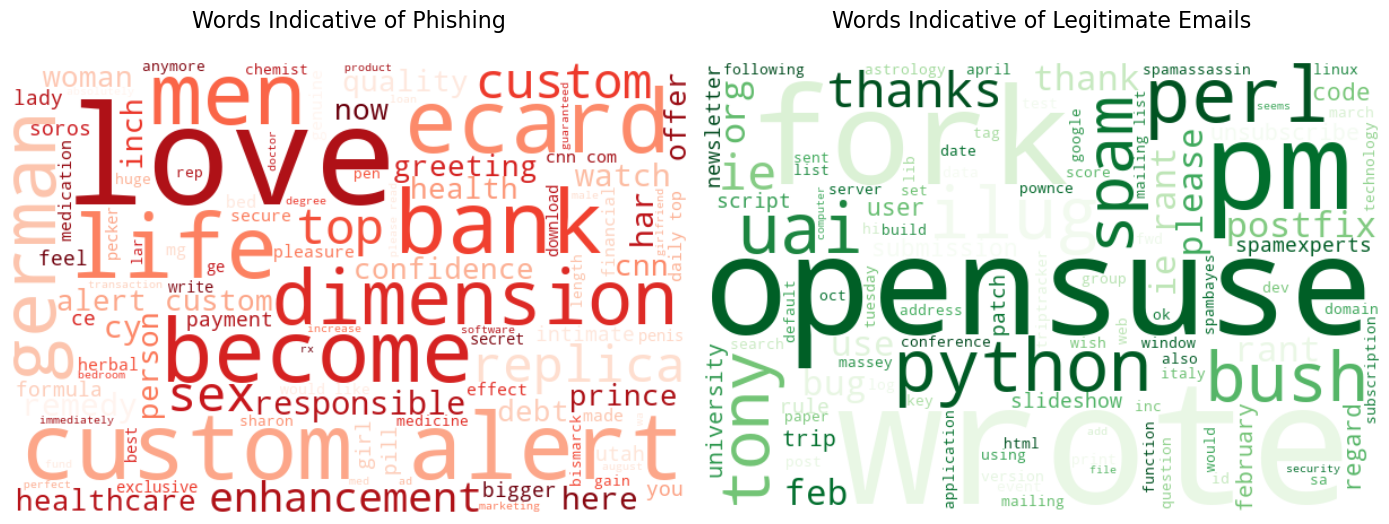

In [6]:
feature_names = tfidf.get_feature_names_out()
coefficients = best_model.coef_[0]  # Use best_model from grid search if available

word_weights = dict(zip(feature_names, coefficients))

phishing_words = {word: weight for word, weight in word_weights.items() if weight > 0}
legit_words = {word: -weight for word, weight in word_weights.items() if weight < 0}

phishing_wc = WordCloud(width=600, height=400, background_color='white', colormap='Reds', max_words=100).generate_from_frequencies(phishing_words)
legit_wc = WordCloud(width=600, height=400, background_color='white', colormap='Greens', max_words=100).generate_from_frequencies(legit_words)

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].imshow(phishing_wc, interpolation='bilinear')
axs[0].set_title('Words Indicative of Phishing\n', fontsize=16)
axs[0].axis('off')

axs[1].imshow(legit_wc, interpolation='bilinear')
axs[1].set_title('Words Indicative of Legitimate Emails\n', fontsize=16)
axs[1].axis('off')

plt.tight_layout()
plt.show()

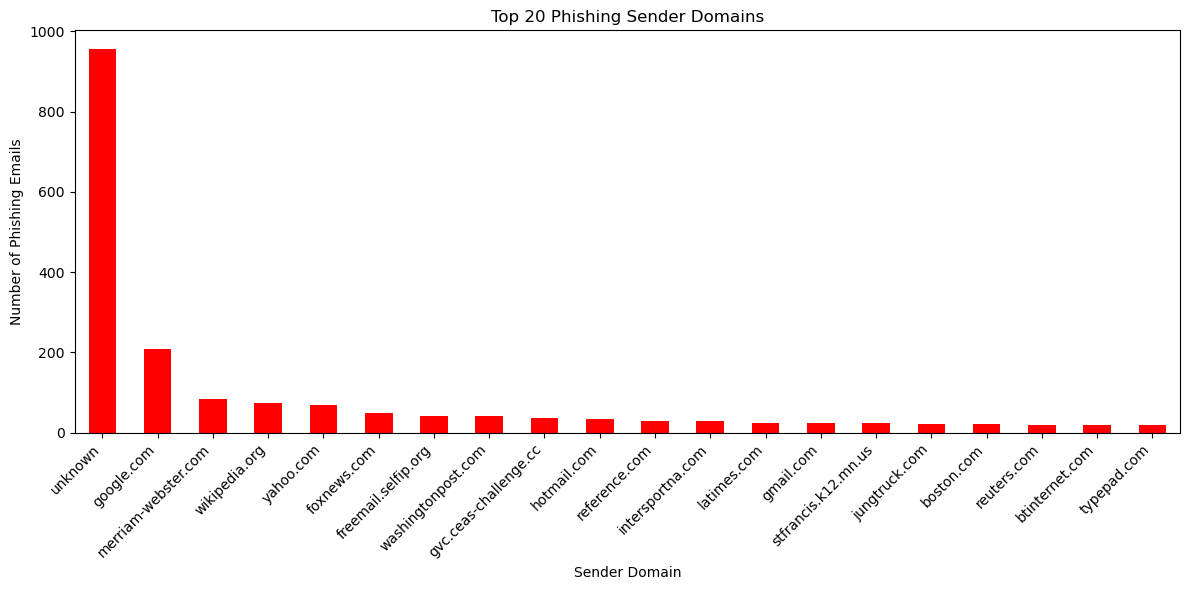

In [7]:
# Filter for phishing emails only
phishing_domains = df[df['label'] == 1]['sender_domain']

# Count the top 20 phishing sender domains
top_phishing_domains = phishing_domains.value_counts().head(20)

plt.figure(figsize=(12,6))
top_phishing_domains.plot(kind='bar', color='red')
plt.title('Top 20 Phishing Sender Domains')
plt.xlabel('Sender Domain')
plt.ylabel('Number of Phishing Emails')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

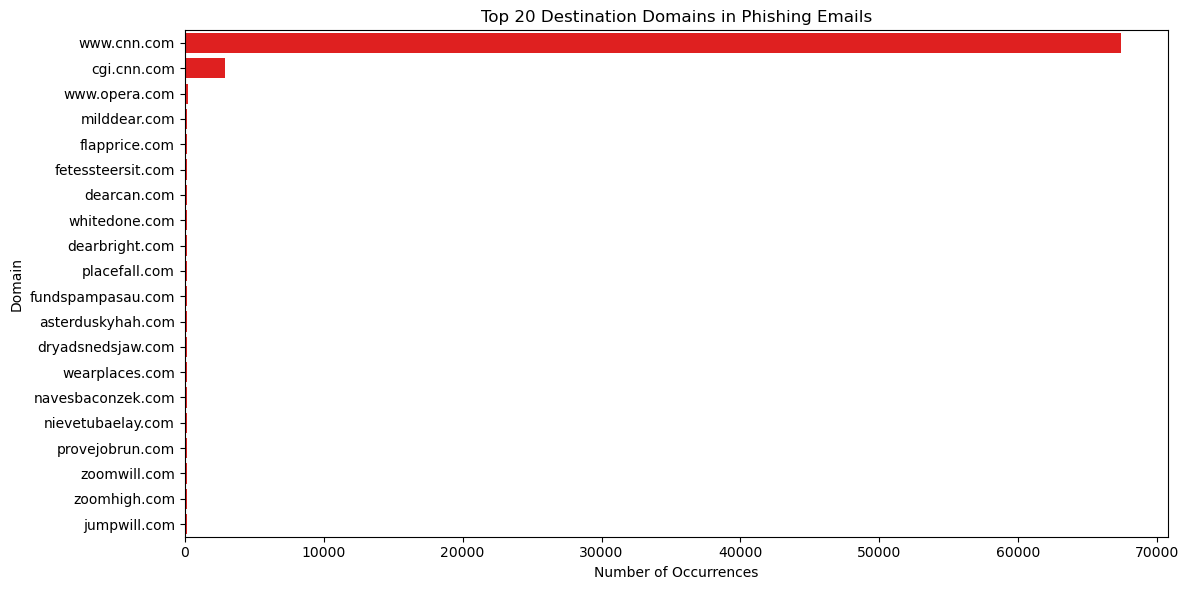

In [8]:
# Filter phishing emails only
phishing_df = df[df['label'] == 1]

# Flatten list of URL domains from phishing emails
all_phishing_domains = []
for domains_list in phishing_df['url_domains']:
    if isinstance(domains_list, list):
        all_phishing_domains.extend(domains_list)

# Count the frequency of each domain
domain_counts = Counter(all_phishing_domains)

# Get the top 20 domains
top_domains = domain_counts.most_common(20)

if top_domains:
    domains, counts = zip(*top_domains)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(domains), color='red')
    plt.title('Top 20 Destination Domains in Phishing Emails')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Domain')
    plt.tight_layout()
    plt.show()
else:
    print("No domains found in phishing emails.")

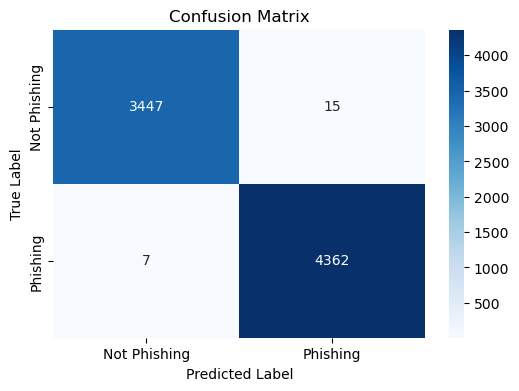

In [9]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()